In [147]:
%matplotlib inline

import numpy as np
import cv2

import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot

import matplotlib.pyplot as plt
from collada import *

from solid.utils import *
import viewscad

#from bpy_lambda import bpy

import sys
import os
    
import src.paths
import src.filesystem

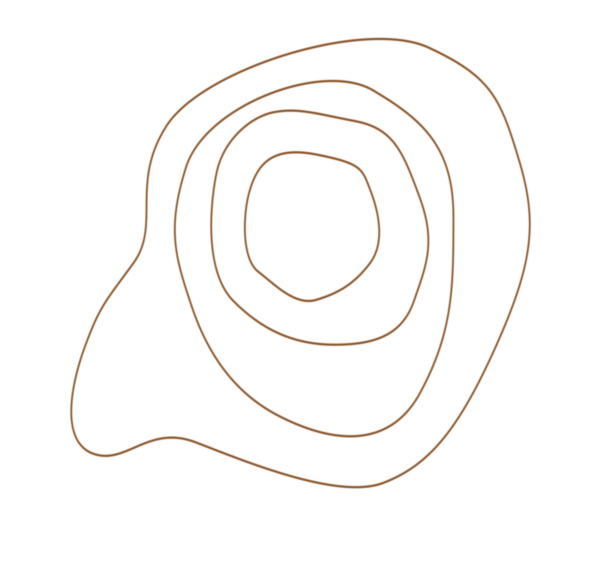

In [131]:
mapPath = "ressources/simplified/contourtest.jpg" #"ressources/simplified/contourtest.jpg" #"ressources/maps/map1.jpg"
img = src.filesystem.readImg(mapPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

height, width, channels = img.shape
blank_image = np.zeros((height, width,1), np.uint8)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")
plt.show()

(4, 2)
(2500, 2500, 1)


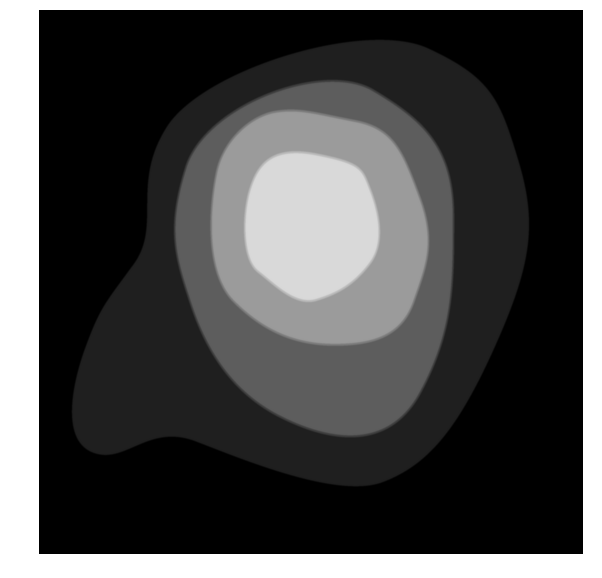

In [156]:


plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_brown = np.array([0, 50, 50])
upper_brown = np.array([20, 255, 255])
filteredBrownsmask = cv2.inRange(hsv, lower_brown, upper_brown)
grayc = gray.copy()

mask = cv2.bitwise_and(grayc,grayc, mask=filteredBrownsmask)



contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #cv2.RETR_LIST

hierarchy = hierarchy[0]

if (len(contours) > 500):
    contours = contours[:500]
    hierarchy = hierarchy[:500]
    

print(np.array( [ [50,50], [50,150], [150, 150], [150,50] ] ).shape)


  
hmap = blank_image.copy()

def fillcontours(hier, conts, img, idx=0, iterations=0):
    curr = hier[idx]
    cont = conts[idx]
    next = curr[0]
    child = curr[2]
    
    l = cont.shape[0]
    
    points = np.empty((l, 2), dtype=np.uint8)
    
    for ptsn in enumerate(cont):
        i, pts = ptsn
        x, y = pts[0][0], pts[0][1]
        points[i][0] = y
        points[i][0] = x
        
    
    colorStep = 255//len(conts)
    c = colorStep* iterations
    cv2.fillPoly(img, pts=[cont], color=(c,c,c))
    
    if (child >= 0):
        fillcontours(hier, conts, img, child, iterations=iterations+1)
    
    if (next >= 0):
        fillcontours(hier, conts, img, next, iterations=iterations)
        

def findFirst(hier):
    curr = hier[0]
    idx = 0
    lastidx = 0
    while (curr[3] >= 0):
        curr = hier[curr[3]]
        lastidx = idx
        idx = curr[3]
    while (curr[1] >= 0):
        curr = hier[curr[1]]
        lastidx = idx
        idx = curr[1]
        
    return lastidx

idx = findFirst(hierarchy)
fillcontours(hierarchy, contours, blank_image, idx=idx)
print(hmap.shape)



contourmask = blank_image.copy()
cv2.drawContours(contourmask, contours, -1, (255, 255, 255), 1)

tst = cv2.cvtColor(hmap, cv2.COLOR_GRAY2BGR)

#tst = cv2.GaussianBlur(tst,(1001,1001),0)


plt.imshow(tst, interpolation="bicubic")
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

#plt.imshow(filteredBrownsmask, interpolation="bicubic")
#plt.show()

#print(contours.shape)

#cv2.imshow("IMG", contourmask)
#cv2.waitKey(0)

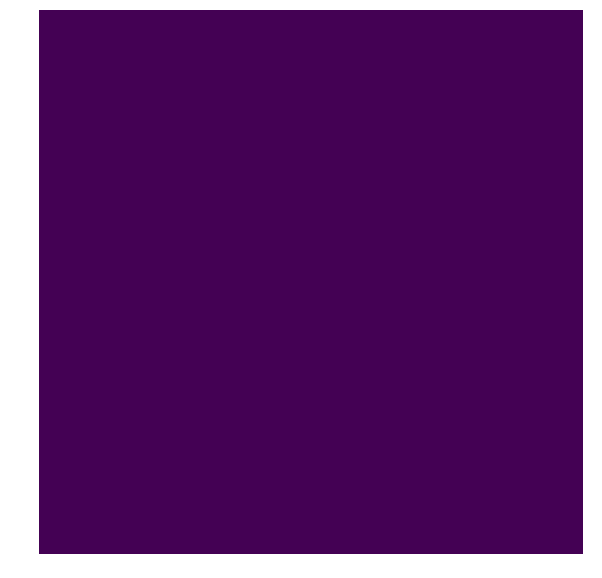

In [143]:
mask1 = cv2.inRange(hsv, np.array([0,70, 50]), np.array([0, 255, 255]))
mask2 = cv2.inRange(hsv, np.array([170, 70, 50]), np.array([180, 255, 255]))
mask = mask1 | mask2

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

[ 898 2076   45]
[1356 1960   42]
[ 912 1682   45]
[1722 2378   38]
[ 624 1338   42]
[1710 2306   48]


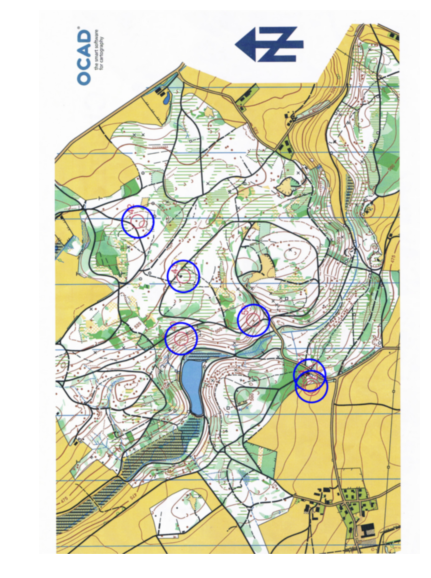

In [86]:
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 30,
              param1=30,
              param2=15,
              minRadius=10,
              maxRadius=50)
circles = np.uint16(np.around(circles))

imgToDraw = np.copy(img)

for circle in circles[0][:6]:
    print(circle)
    cv2.circle(imgToDraw, (circle[0], circle[1]), 100, (0, 0, 255), 10)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(imgToDraw, interpolation="bicubic")

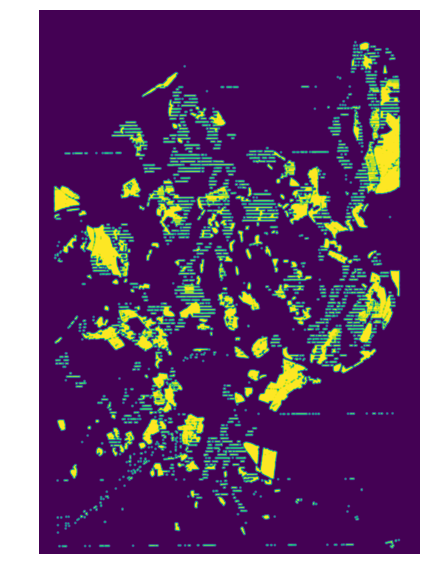

In [88]:
mask = cv2.inRange(hsv, np.array([60, 70, 150]), np.array([80, 255, 255]))

kernel = np.ones((5,5),np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 2)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

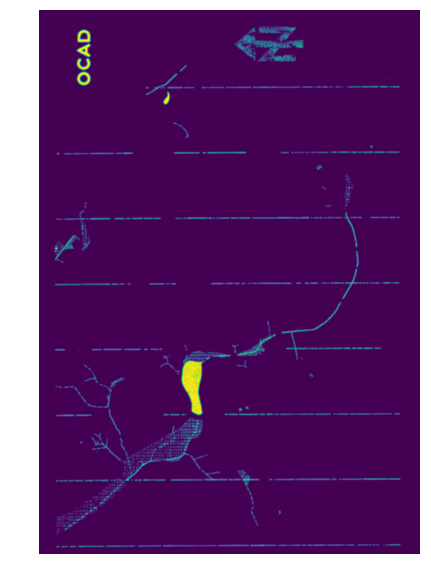

In [89]:
mask = cv2.inRange(hsv, np.array([100, 100, 120]), np.array([110, 255, 255]))

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

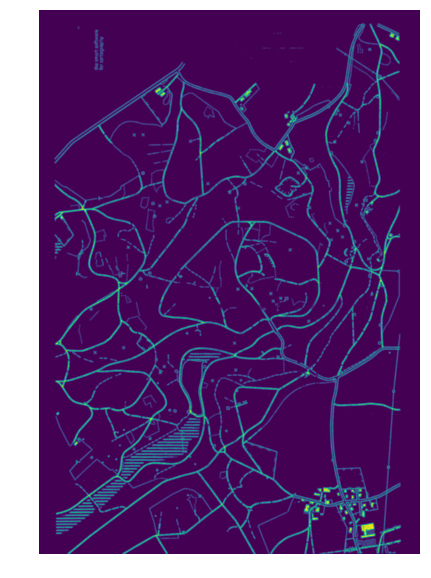

In [92]:
mask = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 60]))

kernel = np.ones((5,5),np.uint8)
#mask = cv2.dilate(mask, kernel, iterations = 2)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

(0.0, 1.0, 0.0, 1.0)

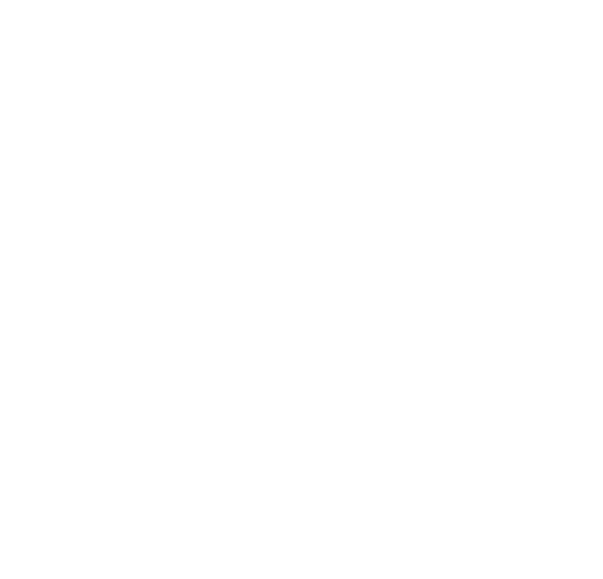

In [92]:
sd = "ressources/maps/map1.jpg"
im = src.filesystem.readImg(sd)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


im = cv2.resize(im,(0, 0), fx=0.1, fy =0.1)
#print(im.shape)

im = im[150:165, 130:150]

#print(im)
cv2.imwrite("ressources/maps/IMG_0183_crop.jpg", im)
plt.figure(figsize=[10,10])
plt.axis('off')
#plt.imshow(im, interpolation="bicubic", cmap='gray')

In [138]:
mesh = Collada()
effect = material.Effect("effect0", [], "phong", diffuse=(0,1,0), specular=(0,0,0))
mat = material.Material("material0", "mymaterial", effect)
mesh.effects.append(effect)
mesh.materials.append(mat)

vert_floats = [-50,50,50,50,50,50,-50,-50,50,50,-50,50,-50,50,-50,50,50,-50,-50,-50,-50,50,-50,-50]
normal_floats = [0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,-1,0,0,
                 -1,0,0,-1,0,0,-1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,-1]
vert_src = source.FloatSource("cubeverts-array", np.array(vert_floats), ('X', 'Y', 'Z'))
normal_src = source.FloatSource("cubenormals-array", np.array(normal_floats), ('X', 'Y', 'Z'))
geom = geometry.Geometry(mesh, "geometry0", "mycube", [vert_src, normal_src])
input_list = source.InputList()
input_list.addInput(0, 'VERTEX', "#cubeverts-array")
input_list.addInput(1, 'NORMAL', "#cubenormals-array")

indices = np.array([0,0,2,1,3,2,0,0,3,2,1,3,0,4,1,5,5,6,0,4,5,6,4,7,6,8,7,9,3,10,6,8,3,10,2,11,0,12,
                       4,13,6,14,0,12,6,14,2,15,3,16,7,17,5,18,3,16,5,18,1,19,5,20,7,21,6,22,5,20,6,22,4,23])

triset = geom.createTriangleSet(indices, input_list, "materialref")
geom.primitives.append(triset)
mesh.geometries.append(geom)

matnode = scene.MaterialNode("materialref", mat, inputs=[])
geomnode = scene.GeometryNode(geom, [matnode])
node = scene.Node("node0", children=[geomnode])

myscene = scene.Scene("myscene", [node])
mesh.scenes.append(myscene)
mesh.scene = myscene

#mesh.write('/tmp/test.dae')

In [145]:
model = Collada()
effect = material.Effect("effect0", [], "phong", diffuse=(0,1,0), specular=(0,0,0))
mat = material.Material("material0", "mymaterial", effect)
model.effects.append(effect)
model.materials.append(mat)

vert_floats = [-50,50,50,50,50,50,-50,-50,50,50,-50,50,-50,50,-50,50,50,-50,-50,-50,-50,50,-50,-50]
normal_floats = [0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,-1,0,0,
                 -1,0,0,-1,0,0,-1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,-1]
vert_src = source.FloatSource("cubeverts-array", np.array(vert_floats), ('X', 'Y', 'Z'))
normal_src = source.FloatSource("cubenormals-array", np.array(normal_floats), ('X', 'Y', 'Z'))
geom = geometry.Geometry(mesh, "geometry0", "mycube", [vert_src, normal_src])
input_list = source.InputList()
input_list.addInput(0, 'VERTEX', "#cubeverts-array")
input_list.addInput(1, 'NORMAL', "#cubenormals-array")

indices = np.array([0,0,2,1,3,2,0,0,3,2,1,3,0,4,1,5,5,6,0,4,5,6,4,7,6,8,7,9,3,10,6,8,3,10,2,11,0,12,
                       4,13,6,14,0,12,6,14,2,15,3,16,7,17,5,18,3,16,5,18,1,19,5,20,7,21,6,22,5,20,6,22,4,23])

triset = geom.createTriangleSet(indices, input_list, "materialref")
geom.primitives.append(triset)
mesh.geometries.append(geom)

matnode = scene.MaterialNode("materialref", mat, inputs=[])
geomnode = scene.GeometryNode(geom, [matnode])
node = scene.Node("node0", children=[geomnode])

myscene = scene.Scene("myscene", [node])
mesh.scenes.append(myscene)
mesh.scene = myscene

#mesh.write('/tmp/test.dae')